In [50]:
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import PorterStemmer

# import these modules 
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,f1_score
from sklearn.metrics import accuracy_score
from bs4 import BeautifulSoup
from contractions import CONTRACTION_MAP

In [51]:
train_data=pd.read_csv(r"C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\HackerRank - Mothers Day\train.csv")
test_data=pd.read_csv(r"C:\Users\gaurav.singh.rawal\Documents\Gaurav\Data Science\Machine Learning-Predictive Analytics\ML-Projects\GIT - ML - Projects\ML_Projects\NLP - Sentiment Analysis\HackerRank - Mothers Day\test.csv")

In [52]:
train_data.head()

,id,original_text,lang,retweet_count,original_author,sentiment_class
0,1.245025e+18,Happy #MothersDay to all you amazing mothers o...,en,0,BeenXXPired,0
1,1.245759e+18,Happy Mothers Day Mum - I'm sorry I can't be t...,en,1,FestiveFeeling,0
2,1.246087e+18,Happy mothers day To all This doing a mothers ...,en,0,KrisAllenSak,-1
3,1.244803e+18,Happy mothers day to this beautiful woman...ro...,en,0,Queenuchee,0
4,1.244876e+18,Remembering the 3 most amazing ladies who made...,en,0,brittan17446794,-1


In [53]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3235 entries, 0 to 3234
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3235 non-null   float64
 1   original_text    3235 non-null   object 
 2   lang             3231 non-null   object 
 3   retweet_count    3231 non-null   object 
 4   original_author  3235 non-null   object 
 5   sentiment_class  3235 non-null   int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 151.8+ KB


In [54]:
temp = train_data.groupby('sentiment_class').count()['original_text'].reset_index().sort_values(by='original_text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment_class,original_text
1,0,1701
0,-1,769
2,1,765


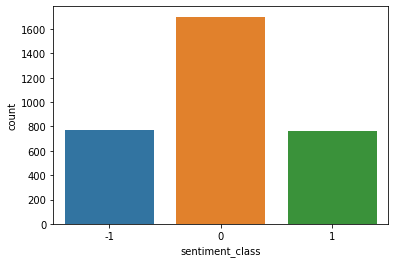

In [55]:
sns.countplot(x='sentiment_class',data=train_data)

In [56]:
test_data.head()

,id,original_text,lang,retweet_count,original_author
0,1.246628e+18,"3. Yeah, I once cooked potatoes when I was 3 y...",en,0,LToddWood
1,1.245898e+18,"Happy Mother's Day to all the mums, step-mums,...",en,0,iiarushii
2,1.244717e+18,"I love the people from the UK, however, when I...",en,0,andreaanderegg
3,1.245730e+18,Happy 81st Birthday Happy Mother’s Day to my m...,en,1,TheBookTweeters
4,1.244636e+18,Happy Mothers day to all those wonderful mothe...,en,0,andreaanderegg


In [57]:
def remove_space(tweet):
    tweet = tweet.strip()
    tweet = tweet.split()
    return " ".join(tweet)

In [58]:
train_data['original_text']=train_data['original_text'].apply(remove_space)

In [59]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [60]:
train_data['original_text']=train_data['original_text'].apply(expand_contractions)

In [61]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

In [62]:
train_data['original_text']=train_data['original_text'].apply(remove_special_characters)

In [63]:
train_data.head()

,id,original_text,lang,retweet_count,original_author,sentiment_class
0,1.245025e+18,Happy MothersDay to all you amazing mothers ou...,en,0,BeenXXPired,0
1,1.245759e+18,Happy Mothers Day Mum I am sorry I cannot be ...,en,1,FestiveFeeling,0
2,1.246087e+18,Happy mothers day To all This doing a mothers ...,en,0,KrisAllenSak,-1
3,1.244803e+18,Happy mothers day to this beautiful womanroyal...,en,0,Queenuchee,0
4,1.244876e+18,Remembering the 3 most amazing ladies who made...,en,0,brittan17446794,-1


In [64]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [65]:
train_data['original_text']=train_data['original_text'].apply(clean_text)

In [66]:
def remove_stopwords(text, is_lower_case=False):
    # Setting stopwords
    stop_words = set(stopwords.words('english'))
    stop_words.remove("not")
    stop_words.remove("no")
    stop_words.remove("shouldn't")

    
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stop_words]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [67]:
train_data['original_text']=train_data['original_text'].apply(remove_stopwords)

In [68]:
def text_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

In [69]:
train_data['original_text']=train_data['original_text'].apply(text_stemmer)

In [70]:
train_data.head()

,id,original_text,lang,retweet_count,original_author,sentiment_class
0,1.245025e+18,happi mothersday amaz mother know hard not abl...,en,0,BeenXXPired,0
1,1.245759e+18,happi mother day mum sorri not bring mother da...,en,1,FestiveFeeling,0
2,1.246087e+18,happi mother day mother day work today quiet t...,en,0,KrisAllenSak,-1
3,1.244803e+18,happi mother day beauti womanroyalti sooth mum...,en,0,Queenuchee,0
4,1.244876e+18,rememb amaz ladi made late grandmoth iri mum c...,en,0,brittan17446794,-1


In [71]:
def lemmatize_text(text):
    word_list = nltk.word_tokenize(text)
    lemmatizer = WordNetLemmatizer() 
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])

    return lemmatized_output

In [72]:
train_data['original_text']=train_data['original_text'].apply(lemmatize_text)

In [73]:
train_data.head()

,id,original_text,lang,retweet_count,original_author,sentiment_class
0,1.245025e+18,happi mothersday amaz mother know hard not abl...,en,0,BeenXXPired,0
1,1.245759e+18,happi mother day mum sorri not bring mother da...,en,1,FestiveFeeling,0
2,1.246087e+18,happi mother day mother day work today quiet t...,en,0,KrisAllenSak,-1
3,1.244803e+18,happi mother day beauti womanroyalti sooth mum...,en,0,Queenuchee,0
4,1.244876e+18,rememb amaz ladi made late grandmoth iri mum c...,en,0,brittan17446794,-1


In [74]:
train_data['temp_list'] = train_data['original_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train_data['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,mother,4492
1,day,3785
2,happi,3453
3,mum,1681
4,mothersday,1607
5,love,1284
6,httpswww,869
7,not,609
8,today,534
9,u,488


In [75]:
train_data["original_text"]= train_data["original_text"].str.replace("mum", "mother", case = False)
train_data["original_text"]= train_data["original_text"].str.replace("mom", "mother", case = False)
train_data["original_text"]= train_data["original_text"].str.replace("mothersday","mother day") 
train_data["original_text"]= train_data["original_text"].str.replace("httpswww","") 
train_data["original_text"]= train_data["original_text"].str.replace("http","") 
train_data["original_text"]= train_data["original_text"].str.replace("u","") 

In [76]:
train_data.head()

,id,original_text,lang,retweet_count,original_author,sentiment_class,temp_list
0,1.245025e+18,happi mother day amaz mother know hard not abl...,en,0,BeenXXPired,0,"[happi, mothersday, amaz, mother, know, hard, ..."
1,1.245759e+18,happi mother day mother sorri not bring mother...,en,1,FestiveFeeling,0,"[happi, mother, day, mum, sorri, not, bring, m..."
2,1.246087e+18,happi mother day mother day work today qiet ti...,en,0,KrisAllenSak,-1,"[happi, mother, day, mother, day, work, today,..."
3,1.244803e+18,happi mother day beati womanroyalti sooth moth...,en,0,Queenuchee,0,"[happi, mother, day, beauti, womanroyalti, soo..."
4,1.244876e+18,rememb amaz ladi made late grandmoth iri mothe...,en,0,brittan17446794,-1,"[rememb, amaz, ladi, made, late, grandmoth, ir..."


In [77]:
train_data['text_list'] = train_data['original_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train_data['text_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,mother,8097
1,day,5639
2,happi,3453
3,love,1284
4,not,609
5,today,534
6,thank,392
7,wish,371
8,one,340
9,amaz,336


In [78]:
train_data.head()

,id,original_text,lang,retweet_count,original_author,sentiment_class,temp_list,text_list
0,1.245025e+18,happi mother day amaz mother know hard not abl...,en,0,BeenXXPired,0,"[happi, mothersday, amaz, mother, know, hard, ...","[happi, mother, day, amaz, mother, know, hard,..."
1,1.245759e+18,happi mother day mother sorri not bring mother...,en,1,FestiveFeeling,0,"[happi, mother, day, mum, sorri, not, bring, m...","[happi, mother, day, mother, sorri, not, bring..."
2,1.246087e+18,happi mother day mother day work today qiet ti...,en,0,KrisAllenSak,-1,"[happi, mother, day, mother, day, work, today,...","[happi, mother, day, mother, day, work, today,..."
3,1.244803e+18,happi mother day beati womanroyalti sooth moth...,en,0,Queenuchee,0,"[happi, mother, day, beauti, womanroyalti, soo...","[happi, mother, day, beati, womanroyalti, soot..."
4,1.244876e+18,rememb amaz ladi made late grandmoth iri mothe...,en,0,brittan17446794,-1,"[rememb, amaz, ladi, made, late, grandmoth, ir...","[rememb, amaz, ladi, made, late, grandmoth, ir..."


In [79]:
train_data=train_data.drop(['temp_list'],axis=1)

In [80]:
train_data.head()

,id,original_text,lang,retweet_count,original_author,sentiment_class,text_list
0,1.245025e+18,happi mother day amaz mother know hard not abl...,en,0,BeenXXPired,0,"[happi, mother, day, amaz, mother, know, hard,..."
1,1.245759e+18,happi mother day mother sorri not bring mother...,en,1,FestiveFeeling,0,"[happi, mother, day, mother, sorri, not, bring..."
2,1.246087e+18,happi mother day mother day work today qiet ti...,en,0,KrisAllenSak,-1,"[happi, mother, day, mother, day, work, today,..."
3,1.244803e+18,happi mother day beati womanroyalti sooth moth...,en,0,Queenuchee,0,"[happi, mother, day, beati, womanroyalti, soot..."
4,1.244876e+18,rememb amaz ladi made late grandmoth iri mothe...,en,0,brittan17446794,-1,"[rememb, amaz, ladi, made, late, grandmoth, ir..."


In [81]:
positive_tweet = train_data[train_data['sentiment_class']==1]
negative_tweet = train_data[train_data['sentiment_class']==-1]
neutral_tweet = train_data[train_data['sentiment_class']==0]

In [82]:
# most common positive words
top_positive = Counter([item for sublist in positive_tweet['text_list'] for item in sublist])
temp_positive = pd.DataFrame(top_positive.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,mother,1924
1,day,1308
2,happi,812
3,love,288
4,not,129
5,today,120
6,wish,100
7,thank,92
8,amaz,85
9,hope,77


In [83]:
# most common negative words
top_negative = Counter([item for sublist in negative_tweet['text_list'] for item in sublist])
temp_negative = pd.DataFrame(top_negative.most_common(20))
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
0,mother,1911
1,day,1314
2,happi,811
3,love,347
4,not,153
5,today,124
6,thank,98
7,one,89
8,wish,89
9,time,80


In [84]:
# most common negative words
top_neutral = Counter([item for sublist in neutral_tweet['text_list'] for item in sublist])
temp_neutral = pd.DataFrame(top_neutral.most_common(20))
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Oranges')

,Common_words,count
0,mother,4262
1,day,3017
2,happi,1830
3,love,649
4,not,327
5,today,290
6,thank,202
7,one,184
8,wish,182
9,amaz,178


In [85]:
# Create feature vectors
vectorizer = TfidfVectorizer(min_df=5,ngram_range=(1, 2),
                                 max_df = 0.8,
                                 sublinear_tf=True,
                                 use_idf=True)


In [86]:
train_vectors = vectorizer.fit_transform(train_data['original_text'])
#test_vectors = vectorizer.transform(test_data['original_text'])

In [88]:
train_data['tweet_length']=train_data['original_text'].apply(lambda x:len(str(x).split()))

In [89]:
train_vectors_df=pd.DataFrame(train_vectors.toarray(), columns=vectorizer.get_feature_names())
#test_vectors_df=pd.DataFrame(test_vectors.toarray(), columns=vectorizer.get_feature_names())

In [90]:
train_df=pd.concat([train_vectors_df,train_data[['retweet_count','sentiment_class','lang','tweet_length']]],axis=1)
#test_df=pd.concat([test_vectors_df,test_data[['retweet_count','lang','tweet_length']]],axis=1)

In [91]:
train_df=train_df[train_df['lang']=='en']
#test_df=test_df[test_df['lang']=='en']

In [92]:
train_df=train_df.drop('lang',axis=1)
#test_df=test_df.drop('lang',axis=1)

In [93]:
y=train_df['sentiment_class']
X=train_df.drop('sentiment_class',axis=1)

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [95]:
# Perform classification with MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)

In [97]:
score=100*(f1_score(y_test,prediction,average='weighted'))

In [98]:
print("\nAccuracy score of Multinomial naive bayes algorithm -----> " + str(score))


Accuracy score of Multinomial naive bayes algorithm -----> 37.743459880655536


In [ ]:
# Perform classification with SVM, kernel=linear
classifier_linear = svm.SVC(kernel='linear')
classifier_linear.fit(X_train, y_train)
prediction_linear = classifier_linear.predict(X_test)


In [ ]:
print(classification_report(y_test, prediction_linear))

In [ ]:
print("\nAccuracy score of Multinomial naive bayes algorithm -----> " + str(accuracy_score(y_test, prediction_linear)))